In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def lrelu(x, leak=0.2):
    return tf.maximum(x, x*leak)

In [3]:
class Model:
    def __init__(self, name, input_dim, output_dim, hidden_dims=[32, 32], 
                 use_batchnorm=True, activation_fn=tf.nn.relu, optimizer=tf.train.AdamOptimizer, lr=0.01):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, [None, input_dim], name='X')
            self.y = tf.placeholder(tf.float32, [None, output_dim], name='y')
            self.mode = tf.placeholder(tf.bool, name='train_mode')

            net = tf.reshape(self.X, [-1, 28, 28, 1])
            n_filters = 64

            for i in range(2):
                with tf.variable_scope('layer{}'.format(i)):
#                     net = tf.layers.dense(net, h_dim)
                    net = tf.layers.conv2d(inputs=net, filters=n_filters, kernel_size=[5,5], strides=2, 
                                          padding='SAME', use_bias=False)
                    if use_batchnorm:
                        net = tf.layers.batch_normalization(net, training=self.mode)
                    net = activation_fn(net)
                
                n_filters = n_filters * 2

            net = tf.contrib.layers.flatten(net)
            net = tf.layers.dense(net, output_dim)
            
            self.loss = tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=self.y)
            self.loss = tf.reduce_mean(self.loss, name='loss')    
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=name)
            with tf.control_dependencies(update_ops):
                self.train_op = optimizer(lr).minimize(self.loss)

            softmax = tf.nn.softmax(net, name='softmax')
            self.accuracy = tf.equal(tf.argmax(softmax, 1), tf.argmax(self.y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.accuracy, tf.float32))

In [4]:
class Solver:
    def __init__(self, sess, model):
        self.model = model
        self.sess = sess
        
    def train(self, X, y):
        feed = {
            self.model.X: X,
            self.model.y: y,
            self.model.mode: True
        }
        train_op = self.model.train_op
        loss = self.model.loss
        
        return self.sess.run([train_op, loss], feed_dict=feed)
    
    def evaluate(self, X, y, batch_size=None):
        if batch_size:
            N = X.shape[0]
            
            total_loss = 0
            total_acc = 0
            
            for i in range(0, N, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                
                feed = {
                    self.model.X: X_batch,
                    self.model.y: y_batch,
                    self.model.mode: False
                }
                
                loss = self.model.loss
                accuracy = self.model.accuracy
                
                step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed)
                
                total_loss += step_loss * X_batch.shape[0]
                total_acc += step_acc * X_batch.shape[0]
            
            total_loss /= N
            total_acc /= N
            
            return total_loss, total_acc
            
            
        else:
            feed = {
                self.model.X: X,
                self.model.y: y,
                self.model.mode: False
            }
            loss = self.model.loss
            accuracy = self.model.accuracy

            return self.sess.run([loss, accuracy], feed_dict=feed)

In [5]:
mnist.train.images.shape

(55000, 784)

In [6]:
input_dim = 784
output_dim = 10
N = 55000

tf.reset_default_graph()

bn = Model('batchnorm', input_dim, output_dim, use_batchnorm=True, activation_fn=lrelu)
nn = Model('no_norm', input_dim, output_dim, use_batchnorm=False, activation_fn=lrelu)

In [7]:
# sess = tf.InteractiveSession()
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [8]:
writer = tf.summary.FileWriter("./tmp/", sess.graph)

In [9]:
bn_solver = Solver(sess, bn)
nn_solver = Solver(sess, nn)

In [10]:
epoch_n = 20
batch_size = 32

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

for epoch in range(epoch_n):
    for _ in range(N//batch_size):
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        
        _, bn_loss = bn_solver.train(X_batch, y_batch)
        _, nn_loss = nn_solver.train(X_batch, y_batch)       
    
    b_loss, b_acc = bn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)
    n_loss, n_acc = nn_solver.evaluate(mnist.train.images, mnist.train.labels, batch_size)    
#     print(f'[Epoch {epoch}-TRAIN] BN Loss(Acc): {b_loss:.5f}({b_acc:.2%}) NN Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
    print('[Epoch {}-TRAIN] BN Loss(Acc): {:.5f}({:.2%}) NN Loss(Acc): {:.5f}({:.2%})'
          .format(epoch, b_loss, b_acc, n_loss, n_acc))
    train_losses.append([b_loss, n_loss])
    train_accs.append([b_acc, n_acc])
    
    b_loss, b_acc = bn_solver.evaluate(mnist.validation.images, mnist.validation.labels)
    n_loss, n_acc = nn_solver.evaluate(mnist.validation.images, mnist.validation.labels)        
#     print(f'[Epoch {epoch}-VALID] BN Loss(Acc): {b_loss:.5f}({b_acc:.2%}) NN Loss(Acc): {n_loss:.5f}({n_acc:.2%})')
#     print()
#     print()
    print('[Epoch {}-VALID] BN Loss(Acc): {:.5f}({:.2%}) NN Loss(Acc): {:.5f}({:.2%})'
          .format(epoch, b_loss, b_acc, n_loss, n_acc))
    print
    
    valid_losses.append([b_loss, n_loss])
    valid_accs.append([b_acc, n_acc])

[Epoch 0-TRAIN] BN Loss(Acc): 0.11949(96.40%) NN Loss(Acc): 1.94046(93.13%)
[Epoch 0-VALID] BN Loss(Acc): 0.12287(96.44%) NN Loss(Acc): 1.97659(93.42%)

[Epoch 1-TRAIN] BN Loss(Acc): 0.11213(96.59%) NN Loss(Acc): 4.15086(93.86%)
[Epoch 1-VALID] BN Loss(Acc): 0.11534(96.78%) NN Loss(Acc): 3.42519(94.54%)

[Epoch 2-TRAIN] BN Loss(Acc): 0.07064(97.93%) NN Loss(Acc): 1.92954(97.47%)
[Epoch 2-VALID] BN Loss(Acc): 0.08641(97.66%) NN Loss(Acc): 2.56163(97.18%)

[Epoch 3-TRAIN] BN Loss(Acc): 0.07207(97.89%) NN Loss(Acc): 3.55041(96.75%)
[Epoch 3-VALID] BN Loss(Acc): 0.08406(97.82%) NN Loss(Acc): 4.91740(96.44%)

[Epoch 4-TRAIN] BN Loss(Acc): 0.06324(98.41%) NN Loss(Acc): 4.36384(96.75%)
[Epoch 4-VALID] BN Loss(Acc): 0.08552(98.22%) NN Loss(Acc): 5.75392(96.38%)

[Epoch 5-TRAIN] BN Loss(Acc): 0.09923(97.45%) NN Loss(Acc): 3.86303(97.36%)
[Epoch 5-VALID] BN Loss(Acc): 0.14157(97.04%) NN Loss(Acc): 5.67670(96.84%)

[Epoch 6-TRAIN] BN Loss(Acc): 0.07027(98.31%) NN Loss(Acc): 9.03985(95.32%)
[Epoch

In [11]:
bn_solver.evaluate(mnist.test.images, mnist.test.labels)

[0.18615294, 0.98530018]

In [12]:
nn_solver.evaluate(mnist.test.images, mnist.test.labels)  

[22.040361, 0.97420013]

In [13]:
def plot_compare(loss_list, xlim=None):
    
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]
    
    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='use_batchnorm')
    plt.plot(nn, label='no_batchnorm')
    if xlim:
        plt.xlim(xlim)
    plt.legend()
    plt.grid('on')
    plt.show()

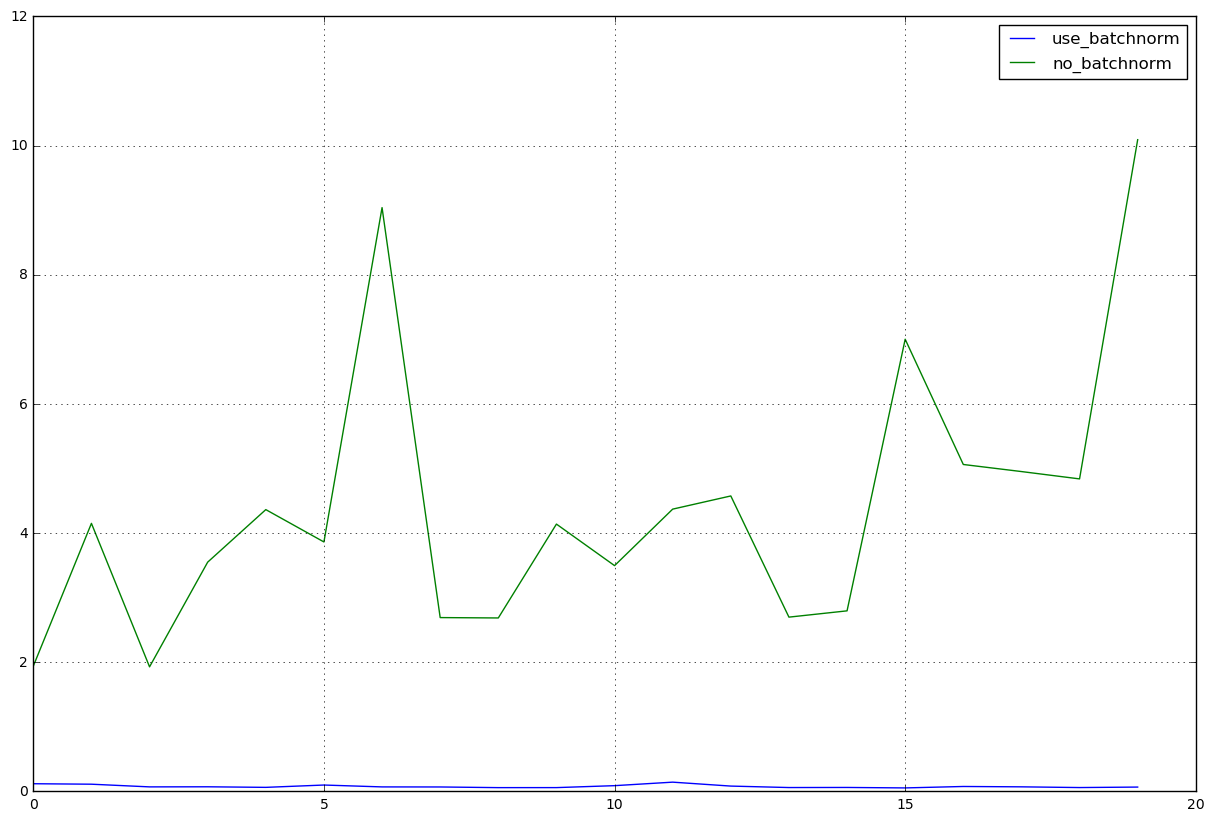

In [14]:
plot_compare(train_losses)

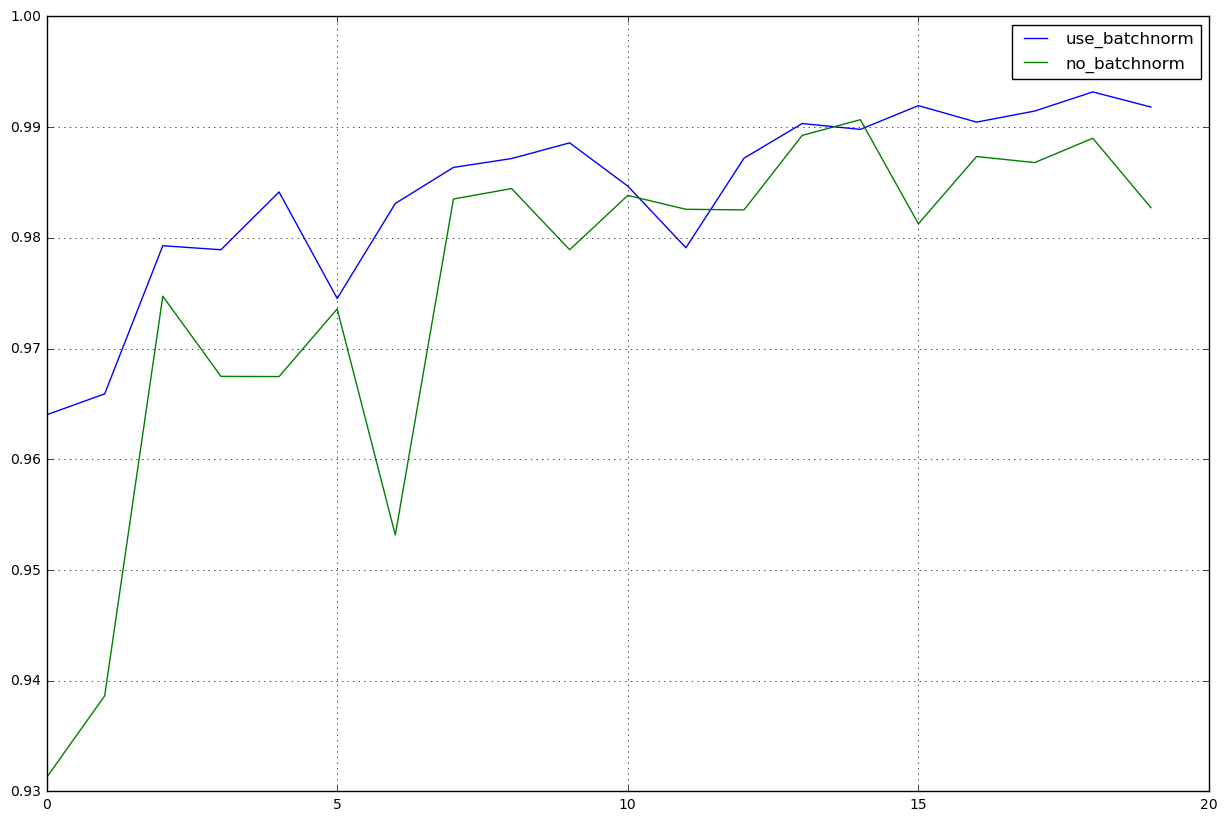

In [15]:
plot_compare(train_accs)

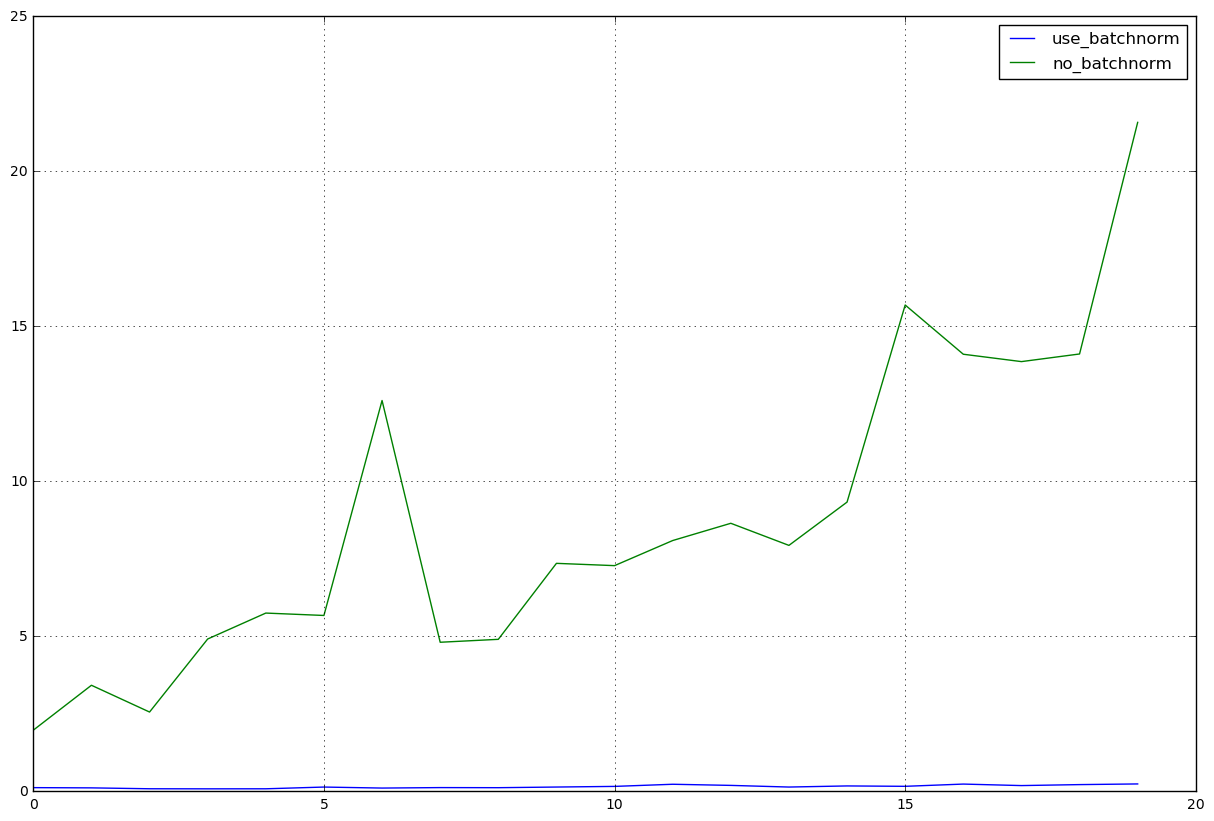

In [16]:
plot_compare(valid_losses)

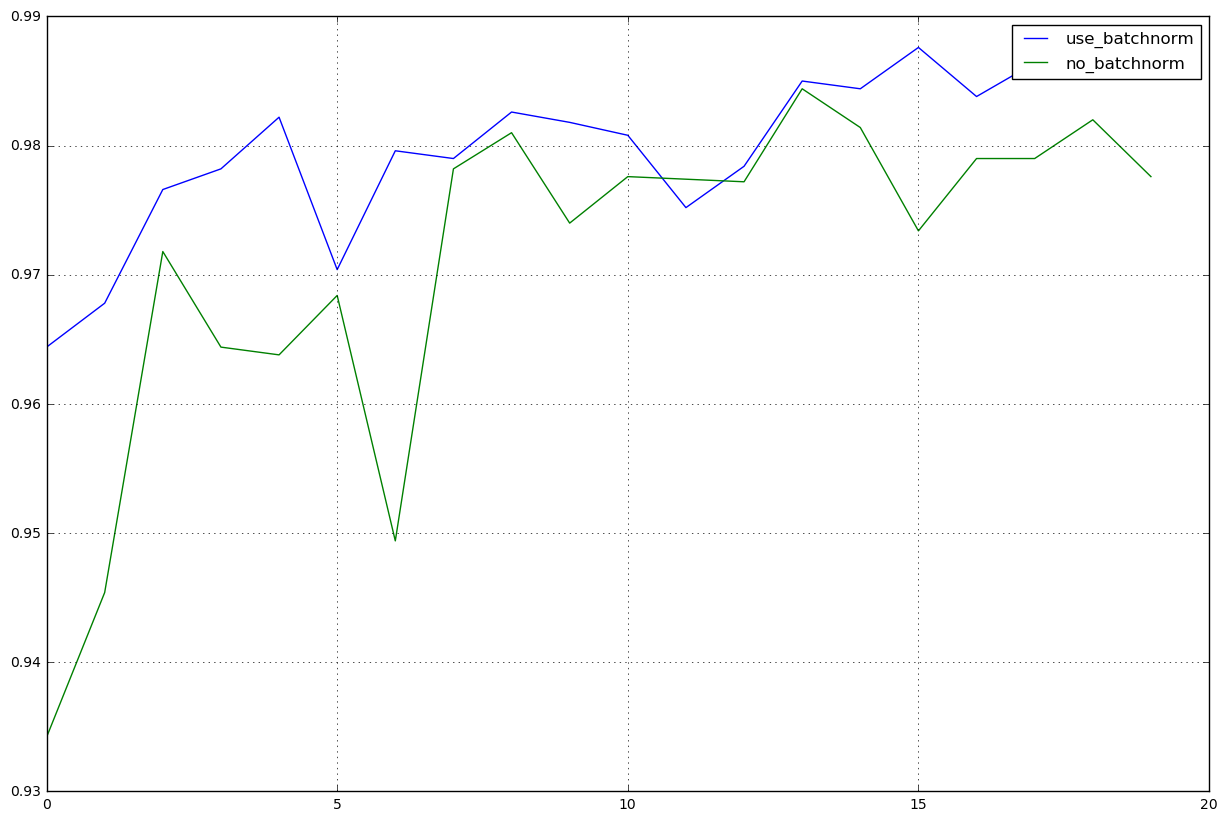

In [17]:
plot_compare(valid_accs)